Nome: Pedro Jorge Oliveira Câmara
DRE: 120182069

In [51]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
from numpy.random import exponential
from typing import List, Tuple, Dict, Callable

Período ocupado: tempo que se passa desde que o sistema inicia com 1 cliente até o sistema ficar vazio novamente.

Cada período ocupado está associado a uam árvore: a raiz é o cliente que inicia o período ocupado. Ele possui um certo número de filhos, igual ao número de indivíduos que chegam ao sistema enquanto o cliente raiz está a ser servido.


### Definindo a função que chama o simulador da fila M/M/1 e realiza os plots

In [52]:
def run_simulator(simulator: Callable, lambda_: float, mi_: float, n_iterations: int = 10000) -> Dict:
    """
    Roda o simulador e plota o gráfico do resultado obtido.
    :param simulator: função do simulador que será rodado
    :param lambda_: parâmetro lambda para o simulador
    :param mi_: parâmetro mi para o simulador
    :param n_iterations: quantidade de iterações do simulador, 10000 rodadas por padrão
    """

    # um dict com todos os dados que precisamos
    data = simulator(lambda_, mi_, n_iterations)

    ci_low_clients, ci_high_clients = calculate_confidence_interval(data['n_clients_per_iter'], data['mean_clients_system'])
    ci_low_wait, ci_high_wait = calculate_confidence_interval(data['wait_time_list'], data['mean_total_wait'])

    rho = lambda_ / mi_
    print(f"--Confidence interval endpoints for mean clients:")
    print(f"Low: {round(ci_low_clients, 2)}")
    print(f"High: {round(ci_high_clients, 2)}")
    print(f"\nMean number of waiting in system: {round(data['mean_total_wait'], 2)}")
    print(f"--Confidence interval endpoints for mean time:")
    print(f"Low: {round(ci_low_wait, 2)}")
    print(f"High: {round(ci_high_wait, 2)}")

    print(f"\nFree period mean: {round(data['mean_busy_time'], 2)}")
    print(f"Confidence interval for free period:")
    low, high = calculate_confidence_interval(data['busy_time'], data['mean_busy_time'])
    print(f"Low: {round(low,2)}")
    print(f"High: {round(high,2)}")
    print(f"Busy period mean: {round(1-data['mean_busy_time'], 2)}")
    print(f"Busy period analytic (via s = G(s): {np.exp(-rho)}")
    fig, axis = plt.subplots(1, 3, figsize=(10, 4))

    axis[0].plot(data['simulation_time_list'], data['n_clients_per_iter'])
    axis[0].set_xlabel("Simulation time")
    axis[0].set_ylabel("Number of clients in system")
    axis[0].set_title(f"Média de clientes no sistema: {data['mean_clients_system']}")

    y = np.sort(data['n_clients_per_iter'])
    n = len(y)
    cdf = np.arange(1, n+1) / n
    axis[1].plot(y, cdf, label="CDF")
    axis[1].set_xlabel('Samples')
    axis[1].set_ylabel('Cumulative Probability')
    axis[1].set_title('CDF número de clientes')

    y = np.sort(data['wait_time_list'])
    n = len(y)
    cdf = np.arange(1, n+1) / n
    axis[2].plot(y, cdf, label="CDF")
    axis[2].set_xlabel('Samples')
    axis[2].set_ylabel('Cumulative Probability')
    axis[2].set_title('CDF tempo de espera')

    plt.tight_layout()
    plt.show()

    return data

### Definindo a função para o cálculo dos intervalos de confiança

In [53]:
def calculate_confidence_interval(sample: List, sample_mean: float) -> Tuple:
    std = 0
    n = len(sample)
    for e in sample:
        std += (np.power(e-sample_mean, 2) / (n-1))

    low = sample_mean - 1.96*(std/np.sqrt(n))
    high = sample_mean + 1.96*(std/np.sqrt(n))

    return low, high

### Definindo o simulador da fila M/M/1

In [54]:
def simulator(lambda_: float, mi_: float, n_iterations: int):
    """
    :param lambda_: taxa de chegada de clientes
    :param mi_: taxa de serviço
    :param n_iterations: número de rodadas
    :return: A dict with keys
        'sample_arrival_list',
        'sample_departure_list',
        'simulation_time_list',
        'wait_time_list',
        'n_clients_per_iter',
        'mean_clients_system',
        'mean_total_wait',
        'mean_queue_wait',
        'mean_busy_time',
        'busy_time',
        'clients_left_behind'.
    """
    served_clients = 0
    n_clients_system = 0
    area_n_clients = 0

    simulation_time = 0.0
    total_wait_time = 0.0

    n_clients_per_iter = [0]
    wait_time_list = []
    simulation_time_list = [0]
    sample_departure_list = []
    sample_arrival_list = []
    queue = []
    busy_time = []

    clients_left_behind = []

    while simulation_time < n_iterations:
        sample_arrival = exponential(1/lambda_)
        sample_departure = exponential(1/mi_)

        if sample_arrival < sample_departure:
            simulation_time += sample_arrival
            queue.append(simulation_time)
            n_clients_system += 1
            area_n_clients += n_clients_system
            sample_arrival_list.append(sample_arrival)

        else:
            simulation_time += sample_departure
            if queue:
                time_client_out = queue.pop(0)
                sample_departure_list.append(sample_departure)
                total_wait_time += (simulation_time - time_client_out)
                wait_time_list.append(simulation_time - time_client_out)
                served_clients += 1
                n_clients_system -= 1
                area_n_clients += n_clients_system
                clients_left_behind.append(len(queue))
            else:
                busy_time.append(sample_departure)

        n_clients_per_iter.append(n_clients_system)
        simulation_time_list.append(simulation_time)

    mean_wait_queue = total_wait_time / served_clients
    mean_total_wait = mean_wait_queue + 1/mi_
    mean_clients_system = area_n_clients / simulation_time
    mean_busy_time = sum(busy_time) / simulation_time

    with open(f'data_lambda_{lambda_}_mu_{mi_}.txt', 'w') as f:
        for c in clients_left_behind:
            f.write(f'\n{c}')

    return {
        'sample_arrival_list':  sample_arrival_list,
        'sample_departure_list': sample_departure_list,
        'simulation_time_list': simulation_time_list,
        'wait_time_list': wait_time_list,
        'n_clients_per_iter': n_clients_per_iter,
        'mean_clients_system': mean_clients_system,
        'mean_total_wait': mean_total_wait,
        'mean_queue_wait': mean_wait_queue,
        'mean_busy_time': mean_busy_time,
        'busy_time': busy_time,
        'clients_left_behind': clients_left_behind
    }


### Rodando com os parâmetros ${\lambda} = 1$ e ${\mu} = 2$

--Confidence interval endpoints for mean clients:
Low: 3.0
High: 3.14

Mean number of waiting in system: 1.49
--Confidence interval endpoints for mean time:
Low: 1.47
High: 1.51

Free period mean: 0.34
Confidence interval for free period:
Low: 0.34
High: 0.34
Busy period mean: 0.66
Busy period analytic (via s = G(s): 0.6065306597126334


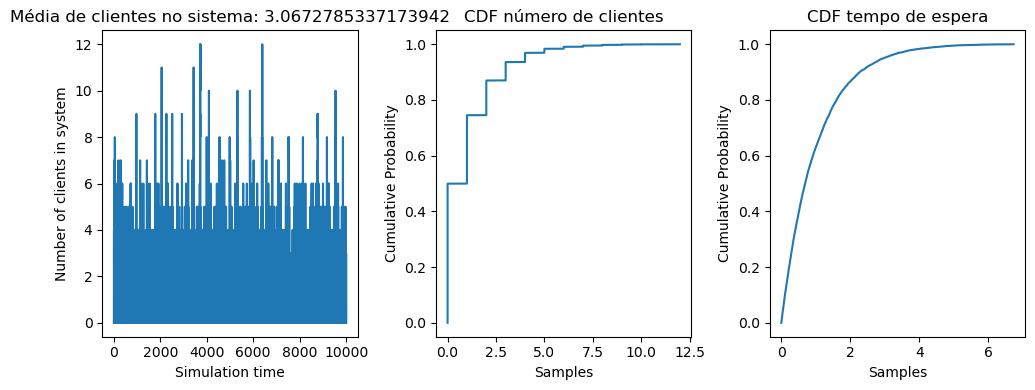

{'sample_arrival_list': [0.2642764729623462,
  0.7053821069486513,
  0.10110599686151096,
  0.30436939341561764,
  0.032214806808701056,
  1.419221464763518,
  0.43170370542310027,
  0.11032702061924231,
  0.10915444108736687,
  0.42534022131149374,
  0.046517874524874464,
  0.11248930367862561,
  0.15454967133583616,
  0.5435015597162091,
  0.42762652178649946,
  0.5133579172009985,
  0.13392116975130275,
  0.39924709205338077,
  0.4575573458568789,
  0.050892645562160894,
  0.5389382438739572,
  0.286018085239301,
  0.19303827455303432,
  0.4233638239853301,
  0.5426356663959971,
  1.6636700714266146,
  0.7116332490247333,
  0.15610223565150738,
  0.21428936215765473,
  1.003140416223404,
  0.32475870659006567,
  0.0017623889323255472,
  0.034041247199507914,
  0.16510471560317608,
  0.3473439833445079,
  0.7060882605280928,
  0.04422647401394172,
  0.0006615481469385567,
  0.2180713035242887,
  0.23591120726056086,
  0.033210193148288956,
  0.0016728971923376714,
  0.326125091840481

In [55]:
run_simulator(simulator, 1, 2)


### Rodando com os parâmetros ${\lambda} = 2$ e ${\mu} = 4$

--Confidence interval endpoints for mean clients:
Low: 5.74
High: 6.17

Mean number of waiting in system: 0.74
--Confidence interval endpoints for mean time:
Low: 0.74
High: 0.75

Free period mean: 0.33
Confidence interval for free period:
Low: 0.33
High: 0.33
Busy period mean: 0.67
Busy period analytic (via s = G(s): 0.6065306597126334


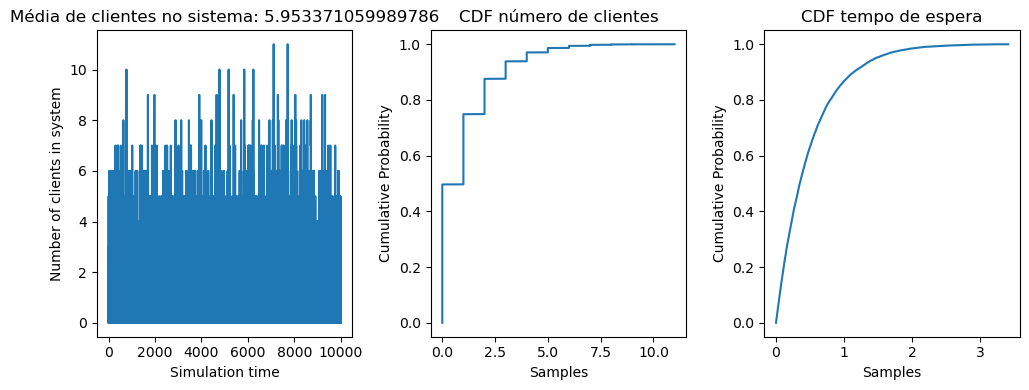

{'sample_arrival_list': [0.16918176578113137,
  1.0309330688851002,
  0.10719351785917777,
  0.10928447523499993,
  0.005209707846445152,
  0.1752361974836302,
  0.032486543254625445,
  0.07577336323030635,
  0.005129527094167206,
  0.08792738031684107,
  0.0790825839623323,
  0.3206184307544718,
  0.08580135715340304,
  0.19336284909063275,
  0.21286051057245972,
  0.06141789913823472,
  0.23395161313529628,
  0.4467660898777944,
  0.12877695049992186,
  0.033644205473983335,
  0.14059475095566132,
  0.08534634799684919,
  0.02883262549012444,
  0.009679146597726217,
  0.06351792375132327,
  0.12589948425222777,
  0.19784771165273207,
  0.17439122318751565,
  0.06703457023628256,
  0.3984513127804911,
  0.10750851828035173,
  0.11888953481779022,
  0.02888743066392219,
  0.017766617580799886,
  0.05368862778394564,
  0.15188060026190509,
  0.10018234819525622,
  0.006855803634784448,
  0.037698010488813403,
  0.040890999807472725,
  0.1783257625080003,
  0.11880744437677106,
  0.13606

In [56]:
run_simulator(simulator, 2, 4)


### Rodando com os parâmetros ${\lambda} = 4$ e ${\mu} = 2$

Aqui podemos ver resultados inconsistentes devido à taxa de chegada ser o dobro da capacidade de serviço. O número de clientes que chega cresce infinitamente, pois não há possibilidade de servir toda a demanda.

--Confidence interval endpoints for mean clients:
Low: -21187964.11
High: 21310861.59

Mean number of waiting in system: 2535.15
--Confidence interval endpoints for mean time:
Low: -27591.36
High: 32661.66

Free period mean: 0.0
Confidence interval for free period:
Low: nan
High: nan
Busy period mean: 1.0
Busy period analytic (via s = G(s): 0.1353352832366127


/tmp/ipykernel_7708/1514119363.py:7: RuntimeWarning: invalid value encountered in double_scalars
  low = sample_mean - 1.96*(std/np.sqrt(n))
/tmp/ipykernel_7708/1514119363.py:8: RuntimeWarning: invalid value encountered in double_scalars
  high = sample_mean + 1.96*(std/np.sqrt(n))


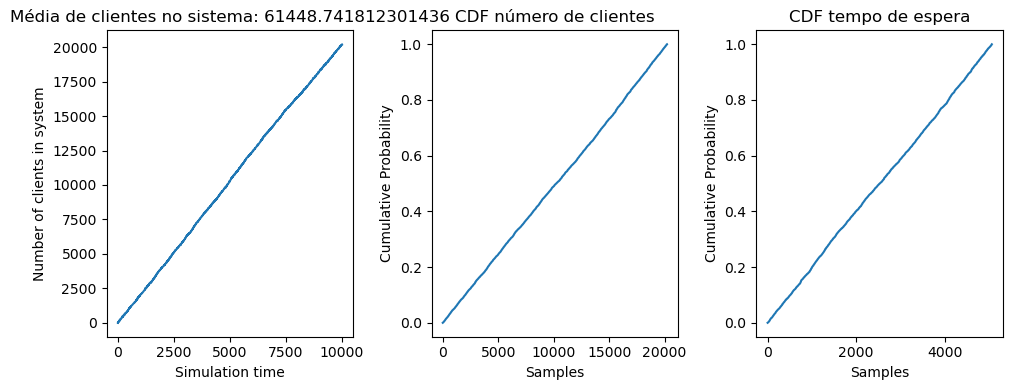

{'sample_arrival_list': [0.17845867411496397,
  0.20419276470189393,
  0.09047398042294708,
  0.05440973628287155,
  0.09785119565351573,
  0.15885532903416888,
  0.09638456308980906,
  0.020869102155272164,
  0.01664835602137713,
  0.015737477025453153,
  0.11389976765820145,
  0.18862292308706258,
  0.2065334827330741,
  0.13982193869158502,
  0.015604132785464344,
  0.041924554477702096,
  0.7112507932557021,
  0.0158928908357776,
  0.09733627211544686,
  0.4474241102557181,
  0.10711208649973632,
  0.3359801302362163,
  0.04221086928493808,
  0.2298920813804684,
  0.11021120640630679,
  0.2757812377935289,
  0.5534667055092906,
  0.3050055709770456,
  0.3943643919142437,
  0.41821238790387655,
  0.01928696131597333,
  0.49741098107150955,
  0.6124988232358215,
  0.1273720267146736,
  0.02392940909003319,
  0.17202710179886124,
  0.3091457885411526,
  0.7518644154601609,
  0.2805202972277556,
  0.0023330967518869245,
  0.06294229269970936,
  0.33641317388386394,
  0.0686010676886996

In [57]:
run_simulator(simulator, 4, 2)


### Considerando agora ${\rho} = 0.1$.

Como sabemos que ${\rho} = \frac{\lambda}{\mu}$, então $\frac{1}{10} = \frac{\lambda}{\mu} \implies \frac{\mu}{10} = \lambda$.

### Resolver analiticamente e obter os valores desejados é relativamente fácil. Temos a equação para o número médio de clientes no sistema: $\frac{\rho}{(1-\rho)}$. Podemos comparar com a simulação.

Pela simulação, temos:

--Confidence interval endpoints for mean clients:
Low: 0.12
High: 0.13

Mean number of waiting in system: 2.08
--Confidence interval endpoints for mean time:
Low: 1.94
High: 2.21

Free period mean: 0.82
Confidence interval for free period:
Low: 0.8
High: 0.83
Busy period mean: 0.18
Busy period analytic (via s = G(s): 0.9048374180359595


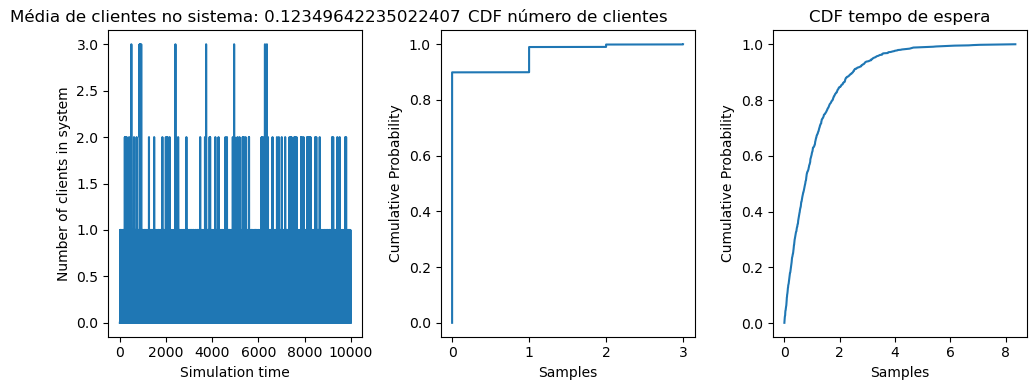

{'sample_arrival_list': [1.5541181399981843,
  0.3928033632144839,
  1.673112543691588,
  0.17366779152913944,
  0.3768085308761329,
  1.8990412979858835,
  0.4452992310369547,
  0.1446545943645825,
  0.4903598018717137,
  1.0526265625769835,
  1.8932633533923038,
  5.292841814171436,
  0.9519346443419758,
  1.1450348226656426,
  2.4097731016039154,
  0.01776922646883833,
  0.2100771862997691,
  0.0999997897548057,
  0.5032555052976115,
  0.09236302406622504,
  0.12103273341133071,
  0.5036003945912575,
  0.6899487764933089,
  2.3139550501707924,
  1.8334046105522661,
  0.023563334669932497,
  0.6877611501842412,
  1.7274841728802668,
  1.0604063205229555,
  4.191835422462758,
  0.29796372718720854,
  2.719130119853724,
  0.20694674082912343,
  1.0673579141052807,
  1.560584900869738,
  1.463220969907014,
  2.1565315803721425,
  0.18858009546170285,
  1.3464854199153082,
  1.342820361646215,
  0.08178952829301306,
  1.0174833826912255,
  0.27791891791563406,
  0.7567053952993599,
  2.1

In [58]:
mu_ = 1
lambda_ = mu_ / 10
rho = lambda_ / mu_

run_simulator(simulator, lambda_, mu_)

### Analiticamente:

In [59]:
rho/((1-rho))

0.11111111111111112

### O que nos dá o valor desejado, isso dentro do intervalo de confiança calculado.

Podemos construir uma cadeia de Markov representando os estados como o número de clientes, incluindo o cliente que está sendo servido. As taxas de chegada $\lambda$ e de serviço $\mu$ nos ajudam a calcular a transição entre os estados.

Dado um estado $i$, transicionar para o estado $i+1$ possui probabilidade $P_{i, i+1} = p = \frac{\lambda}{(\lambda+\mu)}$.
Dado um estado $i$, transicionar para o estado $i-1$ possui probabilidade $P_{i, i-1} = 1 - p$.
Além disso, $P_{0, 1} = 1$

Usei essas notas como apoio: http://www.columbia.edu/~ks20/4106-18-Fall/Notes-CTMC.pdf

### Construindo a cadeia de Markov truncada em um valor finito $n$.

In [60]:
n = 10
transition_matrix = np.zeros((n, n))

p = lambda_ / (lambda_ + mu_)
for i in range(n):
    if i > 0:
        transition_matrix[i, i-1] = p
    if i < n-1:
        transition_matrix[i, i+1] = 1 - p

transition_matrix[0, 1] = 1


### Inspecionando a matriz de transição

In [61]:
transition_matrix


array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.09090909, 0.        , 0.90909091, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.09090909, 0.        , 0.90909091, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.09090909, 0.        , 0.90909091,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.09090909, 0.        ,
        0.90909091, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.09090909,
        0.        , 0.90909091, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.09090909, 0.        , 0.90909091, 0.        , 0.        ],
       [0.        , 0.        , 0.       

### Resolvendo a cadeia pelo método da potência

In [62]:
Pn = np.power(transition_matrix, 10000)

In [63]:
Pn


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Esse problema se resume a uma cadeia de Markov de tempo contínuo, da forma:



Matriz:

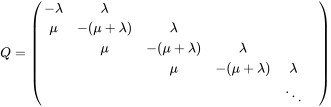

In [64]:
display.Image('ctmc.png')


Com conjunto de estados:

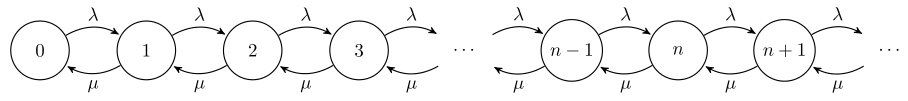

In [65]:
display.Image('statespace.png')


### Podemos enxergar a fila M/M/1 como um processo de ramificação / epidemia.
### Temos uma raiz, que é o primeiro cliente a chegar, e cada indivíduo pode ter descendentes com alguma chance. Esses "descendentes" são os novos clientes chegando ao sistema enquanto alguém é atendido.

Nos plots, temos a fração simulada do período de tempo que o sistema fica ocioso.
Esse valor pode ser obtido analiticamente a partir da equação:

Seja $B$ o período de tempo ocupado. Temos que:

$E(B) = \frac{1/\mu}{1-\rho}$

Assim podemos comparar a simulação com o resultado analítico (feito nos plots).

Se tivermos $\rho > 1$, significa $\lambda > \mu$, o que significa que a tendência é uma explosão no sistema, dado que chegarão mais clientes do que é possível atender.
Com $\rho <= 1$, teremos maior estabilidade, dado que o sistema pode servir relativamente bem os clientes.

Como estamos interpretando o problema como um processo de ramificação, "árvore finita" significa a extinção em algum momento no tempo. Para chegarmos a resultados nesse tópico de interesse, temos o seguinte teorema:

**Dado um processo de ramificação, seja G a função geradora de momentos da sua distribuição offspring. A probabilidade de uma eventual extinção é a menor raiz positiva da equação $s = G(s)$.**

Como a taxa de chegada é $\lambda$ e a taxa de saída é $\mu$, temos que a taxa de utilização do sistema é $\rho = \frac{\lambda}{\mu}$. Temos a distribuição de probabilidade da utilização do sistema, que é uma Poisson: $\frac{\rho^ke^{-\rho}}{k!}$.
Sabemos que a transformada $G(s)$ de uma variável com distribuição de Poisson com parâmetro $\rho$ é dada por: $G(s) = e^{(s-1)\rho}$.
Então precisamos encontrar a menor raiz positiva de $s = e^{(s-1)\rho}$; como uma equação exponencial possui solução única, ela é a resposta de interesse (valores calculados nos prints junto com os plots). De fato, os valores da simulação convergem para o resultado analítico esperado.

### Monte Carlo


Sabemos que a abordagem que utiliza o Monte Carlo Markov Chain serve, basicamente, para amostramos dados de distribuições e estimar parâmetros. Ao analisar uma fila M/M/1 sem as informações da taxa de chegada $\lambda$ ou da de saída $\mu$, podemos recorrer a esse método para conhecermos melhor o comportamento do sistema.

Podemos ter a distribuição a priori, que representa o conhecimento parcial sobre os parâmetros; a verossimilhança dos dados, que nos descreve a probabilidade de observamos esses dados dado um parâmetro $\rho$.

Então o MCMC nos dá amostras da distribuição de interesse, utilizando a estrutura iterativa de proposta de um novo $\rho$, que pode ser aceita ou rejeitada com base na razão de aceitação, levando também em conta a verossimilhança dos dados. Após um número grande de iterações, pela própria propriedade do algoritmo, teremos uma convergência para a distribuição a posteriori.

Função para auxiliar na limpeza esporádica dos arquivos com os dados.

In [77]:
import glob
import os
def clear_files(directory_path = os.getcwd()):
    txt_files = glob.glob(os.path.join(directory_path, "*.txt"))
    for txt_file in txt_files:
        os.remove(txt_file)

# decomentar para excluir os arquivos txt criados
# clear_files()

Reutilizando a função do trabalho anterior sobre MCMC.

In [67]:
def sample(y: float, n: float, c: float = 0.6, K: float = 1.0, initial_state: float = 0.5):
    """
    :param y: Constante dada pelo usuário.
    :param n: Constante dada pelo usuário.
    :param c: Comprimento do intervalo.
    :param K: Constante a ser calculada.
    """

    trials = 10000
    simlist = np.zeros(trials)
    simlist[0] = initial_state

    state = initial_state
    for i in range(1, trials):
        prop = np.random.uniform(state - c/2, state + c/2) # deixando o comprimento igual a 0.6
        acc = (np.power(prop, y) * np.power(1-prop, n) / K) / (np.power(state, y) * np.power(1-state, n) / K)

        if np.random.uniform() < min(1,acc):
            state = prop

        simlist[i] = state

    print(f"Média de rho: {np.mean(simlist)}")
    print(f"Variância de rho: {np.var(simlist)}")

    simlist_ = simlist.copy()
    fig, axis = plt.subplots(1, 2, figsize=(10, 4))

    axis[0].hist(simlist, density=True)
    axis[0].set_xlabel("valores de rho")
    axis[0].set_title("PDF rho")

    y = np.sort(simlist_)
    n = len(simlist_)
    cdf = np.arange(1, n+1) / n
    axis[1].plot(y, cdf, label="CDF")
    axis[1].set_xlabel('valores de rho')
    axis[1].set_ylabel('Cumulative Probability')
    axis[1].set_title('CDF rho')
    plt.show()

    return simlist

Pegando os dados gerados pelo simulador e utilizando os dados com parâmetro $\rho = \frac{1}{2}$

Média de rho: 0.5315295732039081
Variância de rho: 0.0004012448096481608


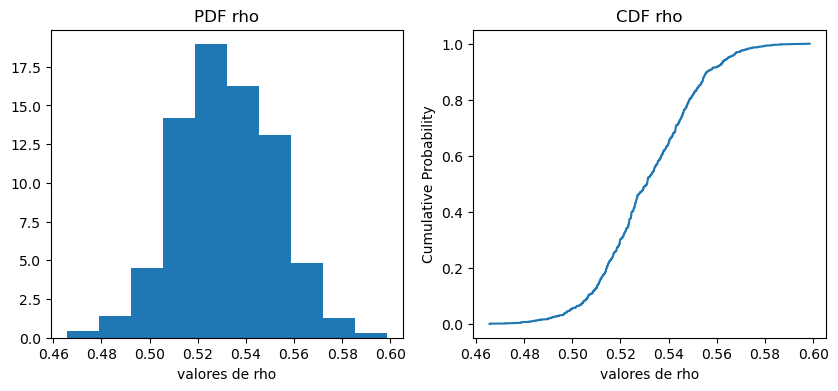

In [68]:
data = []
lambda_ = 1
mu_ = 2

with open(f'data_lambda_{lambda_}_mu_{mu_}.txt') as f:
    for l in f.read():
        if l == '\n':
            continue
        data.append(int(l))

rho = sample(sum(data[0:300]), len(data[0:300]))


In [69]:
rho

array([0.5       , 0.5       , 0.5       , ..., 0.55204883, 0.54161743,
       0.54161743])

In [70]:
rho.mean()


0.5315295732039081

### Considerando $m = 100, y = 25$

Pela equação do número médio de clientes, $E(N) = \frac{\rho}{1-\rho}$, temos:

Média de rho: 0.20337825790637365
Variância de rho: 0.0012508053661777663


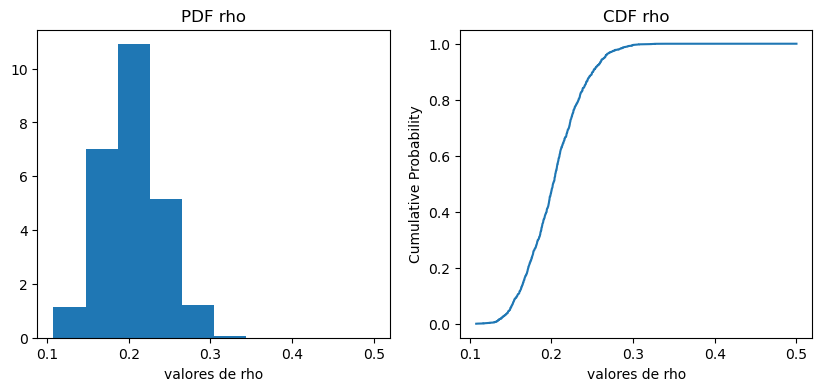

--Confidence interval endpoints for mean clients:
Low: 30.4
High: 45.56

Mean number of waiting in system: 1.24
--Confidence interval endpoints for mean time:
Low: 1.23
High: 1.25

Free period mean: 0.11
Confidence interval for free period:
Low: 0.11
High: 0.11
Busy period mean: 0.89
Busy period analytic (via s = G(s): 0.44932896411722156


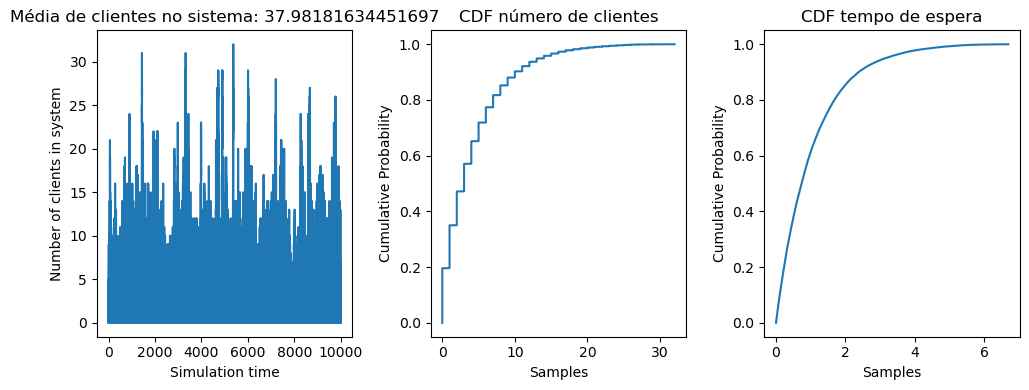

Valor esperado de clientes: 4.000000000000001


In [71]:
rho = sample(y=25, n=100)
rho_mean = rho.mean()

# para rho = 4/5
lambda_ = 4
mu_ = 5
rho = lambda_ / mu_

data = run_simulator(simulator, lambda_, mu_)
y = sum(data['clients_left_behind'])
m = len(data['clients_left_behind'])
e_n = rho / (1-rho)

print(f'Valor esperado de clientes: {e_n}')


### Considerando $m = 100, y = 100$

Média de rho: 0.4999889872532847
Variância de rho: 0.0012269911177762


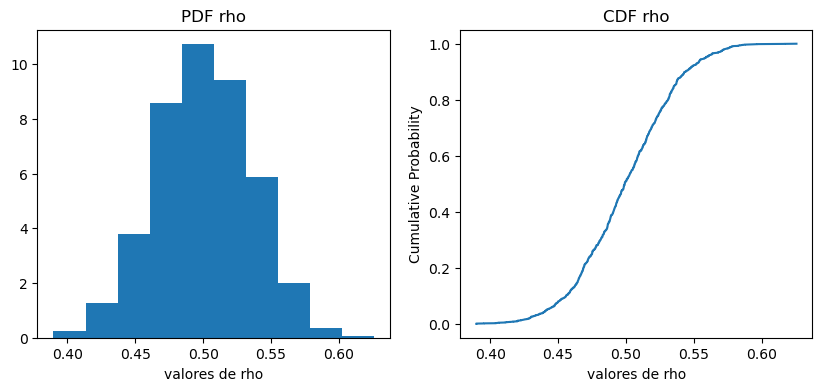

--Confidence interval endpoints for mean clients:
Low: 3.0
High: 3.14

Mean number of waiting in system: 1.51
--Confidence interval endpoints for mean time:
Low: 1.49
High: 1.54

Free period mean: 0.33
Confidence interval for free period:
Low: 0.33
High: 0.33
Busy period mean: 0.67
Busy period analytic (via s = G(s): 0.6065306597126334


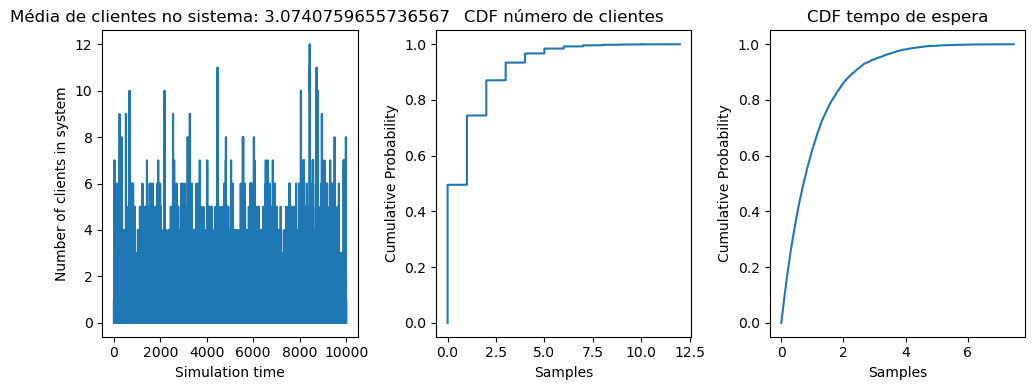

Valor esperado de clientes: 1.0


In [72]:
rho = sample(y=100, n=100)
rho_mean = rho.mean()

lambda_ = 1
mu_ = 2
rho = lambda_ / mu_

data = run_simulator(simulator, lambda_, mu_)
y = sum(data['clients_left_behind'])
m = len(data['clients_left_behind'])
e_n = rho / (1-rho)

print(f'Valor esperado de clientes: {e_n}')


### Considerando $m=100, y = 100, \rho = \frac{3}{2}$

Média de rho: 0.5013113224398364
Variância de rho: 0.0013288710142695492


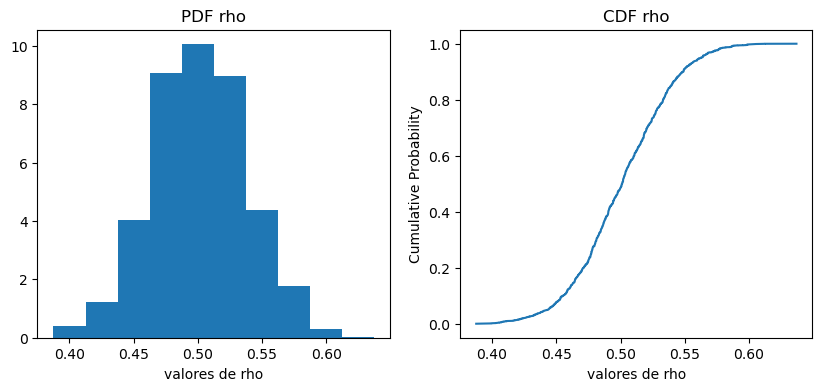

--Confidence interval endpoints for mean clients:
Low: 9.39
High: 10.62

Mean number of waiting in system: 1.35
--Confidence interval endpoints for mean time:
Low: 1.33
High: 1.37

Free period mean: 0.2
Confidence interval for free period:
Low: 0.2
High: 0.2
Busy period mean: 0.8
Busy period analytic (via s = G(s): 0.513417119032592


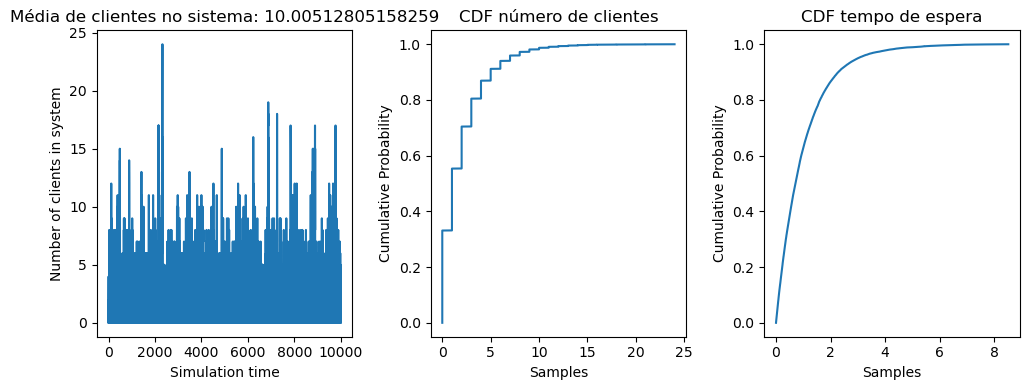

Valor esperado de clientes: 1.9999999999999998


In [73]:
rho = sample(y=100, n=100)
rho_mean = rho.mean()

lambda_ = 2
mu_ = 3
rho = lambda_ / mu_

data = run_simulator(simulator, lambda_, mu_)
y = sum(data['clients_left_behind'])
m = len(data['clients_left_behind'])
e_n = rho / (1-rho)

print(f'Valor esperado de clientes: {e_n}')



### Considerando $m=100, y = 100, \rho = \frac{3}{10}$

Média de rho: 0.5005246704045385
Variância de rho: 0.00124154950869644


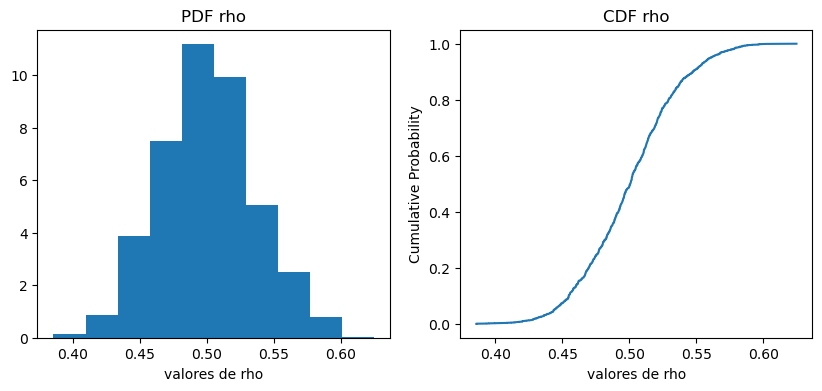

--Confidence interval endpoints for mean clients:
Low: 5.26
High: 5.54

Mean number of waiting in system: 0.24
--Confidence interval endpoints for mean time:
Low: 0.24
High: 0.24

Free period mean: 0.55
Confidence interval for free period:
Low: 0.54
High: 0.55
Busy period mean: 0.45
Busy period analytic (via s = G(s): 0.7408182206817179


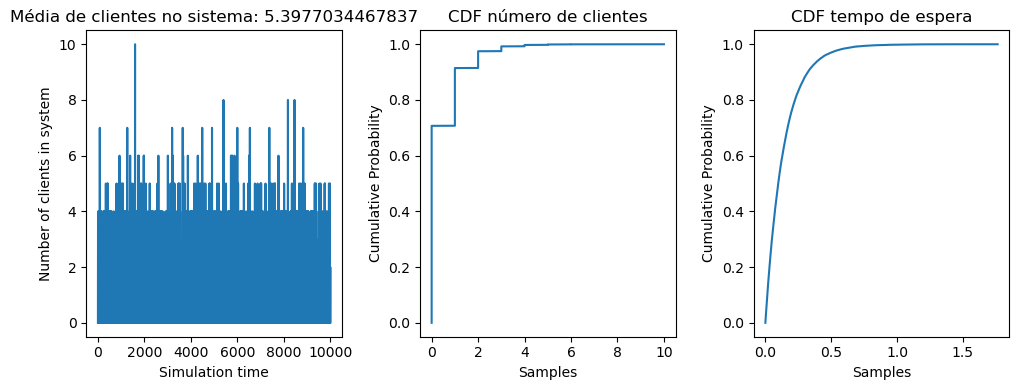

Valor esperado de clientes: 0.4285714285714286


In [74]:
rho = sample(y=100, n=100)
rho_mean = rho.mean()

lambda_ = 3
mu_ = 10
rho = lambda_ / mu_

data = run_simulator(simulator, lambda_, mu_)
y = sum(data['clients_left_behind'])
m = len(data['clients_left_behind'])
e_n = rho / (1-rho)

print(f'Valor esperado de clientes: {e_n}')
